<a href="https://colab.research.google.com/github/Abhs1897/NLP/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install evaluate
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the pac

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate

In [3]:
datasets=datasets.load_dataset("bentrevett/multi30k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [5]:
train_data,valid_data,test_data=datasets["train"],datasets["validation"],datasets["test"]

In [6]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

In [7]:
#Tokenizer
#A tokenizer is used to turn a string into a list of tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

en_nlp=spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [8]:
string="What a lovely day it is today!"
[token.text for token in en_nlp(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [9]:
def tokenize_example(example,en_nlp,de_nlp,max_length,lower,sos_token,eos_token):
  en_toknes=[token.text for token in en_nlp(example["en"])][:max_length]
  de_tokens=[token.text for token in de_nlp(example["de"])][:max_length]

  if lower:
    en_tokens=[text.lower() for text in en_toknes]

  en_tokens=[sos_token]+en_tokens+[eos_token]
  de_tokens=[sos_token]+de_tokens+[eos_token]

  return {"en_tokens":en_tokens, "de_tokens":de_tokens}

In [96]:
max_length=1000
lower=True
eos_token="<eos>"
sos_token="<sos>"

fn_kwargs={
    "en_nlp":en_nlp,
    "de_nlp":de_nlp,
    "max_length":max_length,
    "lower":lower,
    "sos_token":sos_token,
    "eos_token":eos_token
}

train_data=train_data.map(tokenize_example,fn_kwargs=fn_kwargs)
valid_data=valid_data.map(tokenize_example,fn_kwargs=fn_kwargs)
test_data=test_data.map(tokenize_example,fn_kwargs=fn_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [97]:
#Vocab

"""Next, we'll build the vocabulary for the source and target languages. The vocabulary is used to
associate each unique token in our dataset with an index (an integer),
However, what happens if a token exists in our validation and test set, but not in our training set?
In that case, we replace the token with an "unknown token", denoted by <unk>
We use the min_freq argument to not create an index for tokens which appear less than min_freq
When inputting sentences into our model, it is more efficient to pass multiple sentences at once (known as a batch),
instead of one at a time. The requirement for sentences to be batched together is that they all have to be the same length (in terms of the number of tokens).
The majority of our sentences are not the same length, but we can solve this by "padding" (adding <pad> tokens)
the tokenized version of each sentence in a batch until they all have equal tokens to the longest sentence in the batch
"""

min_freq=2
unk_token="<unk>"
pad_token="<pad>"

special_token=[
    unk_token,
    pad_token,
    sos_token,
    eos_token
]

en_vocab=torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_token
)

de_vocab=torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_token
)

In [98]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [99]:
en_vocab.get_stoi()["the"]

7

In [100]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [101]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

In [102]:
#Looking up tokens
tokens=["i","love","programming"]
en_vocab.lookup_indices(tokens)

[956, 2169, 0]

In [103]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', '<unk>']

In [104]:
def numericalize_example(example,en_vocab,de_vocab):
  en_ids=en_vocab.lookup_indices(example["en_tokens"])
  de_ids=de_vocab.lookup_indices(example["de_tokens"])
  return {"en_ids":en_ids,"de_ids":de_ids}

In [105]:
fn_kwargs={"en_vocab":en_vocab, "de_vocab":de_vocab}

train_data=train_data.map(numericalize_example,fn_kwargs=fn_kwargs)
valid_data=valid_data.map(numericalize_example,fn_kwargs=fn_kwargs)
test_data=test_data.map(numericalize_example,fn_kwargs=fn_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [106]:
data_type="torch"
format_columns=["en_ids","de_ids"]

train_data=train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)


valid_data=valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

test_data=test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

In [107]:
def get_collate_fn(pad_index):
  def collate_fn(batch):
    batch_en_ids=[example["en_ids"] for example in batch]
    batch_de_ids=[example["de_ids"] for example in batch]

    batch_en_ids=nn.utils.rnn.pad_sequence(batch_en_ids,padding_value=pad_index)
    batch_de_ids=nn.utils.rnn.pad_sequence(batch_de_ids,padding_value=pad_index)

    batch={
        "en_ids":batch_en_ids,
        "de_ids":batch_de_ids
    }

    return batch

  return collate_fn

In [108]:
def get_data_loader(dataset,batch_size,pad_index,shuffle=True):
  collate_fn=get_collate_fn(pad_index)
  data_loader=torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      collate_fn=collate_fn,
      shuffle=shuffle
  )
  return data_loader

In [109]:
batch_size=128

train_data_loader=get_data_loader(train_data,batch_size,pad_index,shuffle=True)
valid_data_loader=get_data_loader(valid_data,batch_size,pad_index,shuffle=True)
test_data_loader=get_data_loader(test_data,batch_size,pad_index,shuffle=True)

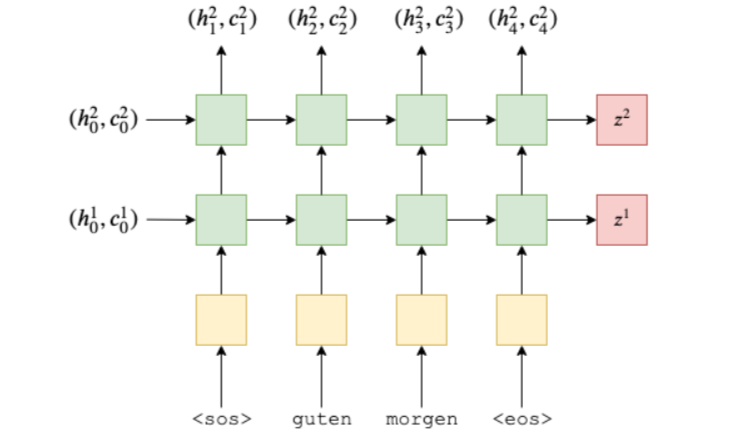

In [110]:
#Building the model

class Encoder(nn.Module):
  def __init__(self,input_dim,embedding_dim,hidden_dim,n_layers,dropout):
    super().__init__()
    self.hidden_dim=hidden_dim
    self.n_layers=n_layers
    self.embedding=nn.Embedding(input_dim,embedding_dim)
    self.rnn=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=dropout)
    self.dropout=nn.Dropout(dropout)
  def forward(self,src):
    #src=[src_length,batch_size]
    embedded=self.dropout(self.embedding(src))
    outputs,(hidden,cell)=self.rnn(embedded)

    return hidden,cell

In [111]:
#Decoder

class Decoder(nn.Module):
  def __init__(self,output_dim,embedding_dim,hidden_dim,n_layers,dropout):
    super().__init__()
    self.output_dim=output_dim
    self.hidden_dim=hidden_dim
    self.embedding=nn.Embedding(output_dim,embedding_dim)
    self.rnn=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=dropout)
    self.fc_out=nn.Linear(hidden_dim,output_dim)
    self.n_layers=n_layers
    self.dropout=nn.Dropout(dropout)
  def forward(self,input,hidden,cell):

    input=input.unsqueeze(0)
    embedded=self.dropout(self.embedding(input))

    output,(hidden,cell)=self.rnn(embedded,(hidden,cell))

    prediction=self.fc_out(output.squeeze(0))

    return prediction,hidden,cell

In [112]:
#Seq2Seq model

class Seq2Seq(nn.Module):
  def __init__(self, encoder,decoder,device):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.device=device

    assert(
        encoder.hidden_dim==decoder.hidden_dim
    ), "Hidden dimensions of encoder and decoder must be equal!"
    assert(
        encoder.n_layers==decoder.n_layers
    ), "Encoder and decoder must have equal number of layers!"

  def forward(self,src,trg,teacher_forcing_ratio):
    batch_size=trg.shape[1]
    trg_length=trg.shape[0]

    trg_vocab_size=self.decoder.output_dim

    outputs=torch.zeros(trg_length,batch_size,trg_vocab_size).to(self.device)

    hidden,cell=self.encoder(src)

    input=trg[0,:]

    for t in range(1,trg_length):

      output,hidden,cell=self.decoder(input,hidden,cell)

      outputs[t]=output

      teacher_force=random.random()<teacher_forcing_ratio

      top1=output.argmax(1)

      input=trg[1] if teacher_force else top1

    return outputs

In [113]:
input_dim=len(de_vocab)
output_dim=len(en_vocab)

encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


encoder=Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout
)



decoder=Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout
)


model=Seq2Seq(encoder,decoder,device).to(device)

In [114]:
#Weight initialization

def init_weights(m):
  for name,param in m.named_parameters():
    nn.init.uniform_(param.data,-0.08,0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8014, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [115]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,939,717 trainable parameters


In [116]:
optimizer=optim.Adam(model.parameters())

In [117]:
criterion=nn.CrossEntropyLoss(ignore_index=pad_index)

In [118]:
def train_fn(model,data_loader,optimizer,crierion,clip,teacher_forcing_ratio,device):
  model.train()
  epoch_loss=0
  for i,batch in enumerate(data_loader):
    src=batch["de_ids"].to(device)
    trg=batch["en_ids"].to(device)

    optimizer.zero_grad()
    output=model(src,trg,teacher_forcing_ratio)

    output_dim=output.shape[-1]

    output=output[1:].view(-1,output_dim)

    trg=trg[1:].view(-1)

    loss=criterion(output,trg)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(),clip)

    optimizer.step()

    epoch_loss+=loss.item()
  return epoch_loss/len(data_loader)

In [119]:
def evaluate_fn(model,data_loader,criterion,device):
  model.eval()
  epoch_loss=0
  with torch.no_grad():
    for i,batch in enumerate(data_loader):
      src=batch["de_ids"].to(device)
      trg=batch["en_ids"].to(device)

      output=model(src,trg,0)

      output_dim=output.shape[-1]

      output=output[1:].view(-1,output_dim)

      trg=trg[1:].view(-1)

      loss=criterion(output,trg)

      epoch_loss+=loss.item()
  return epoch_loss/len(data_loader)

In [120]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 10%|█         | 1/10 [00:46<06:55, 46.17s/it]

	Train Loss:   5.122 | Train PPL: 167.680
	Valid Loss:   4.767 | Valid PPL: 117.508


 20%|██        | 2/10 [01:31<06:07, 45.89s/it]

	Train Loss:   4.693 | Train PPL: 109.172
	Valid Loss:   4.503 | Valid PPL:  90.280


 30%|███       | 3/10 [02:18<05:22, 46.10s/it]

	Train Loss:   4.457 | Train PPL:  86.218
	Valid Loss:   4.317 | Valid PPL:  74.986


 40%|████      | 4/10 [03:04<04:37, 46.28s/it]

	Train Loss:   4.260 | Train PPL:  70.834
	Valid Loss:   4.159 | Valid PPL:  63.996


 50%|█████     | 5/10 [03:50<03:51, 46.24s/it]

	Train Loss:   4.088 | Train PPL:  59.615
	Valid Loss:   4.033 | Valid PPL:  56.406


 60%|██████    | 6/10 [04:36<03:03, 45.94s/it]

	Train Loss:   3.921 | Train PPL:  50.437
	Valid Loss:   3.896 | Valid PPL:  49.199


 70%|███████   | 7/10 [05:22<02:18, 46.12s/it]

	Train Loss:   3.752 | Train PPL:  42.626
	Valid Loss:   3.764 | Valid PPL:  43.129


 80%|████████  | 8/10 [06:09<01:32, 46.17s/it]

	Train Loss:   3.596 | Train PPL:  36.437
	Valid Loss:   3.678 | Valid PPL:  39.571


 90%|█████████ | 9/10 [06:55<00:46, 46.34s/it]

	Train Loss:   3.450 | Train PPL:  31.514
	Valid Loss:   3.613 | Valid PPL:  37.085


100%|██████████| 10/10 [07:41<00:00, 46.16s/it]

	Train Loss:   3.321 | Train PPL:  27.699
	Valid Loss:   3.547 | Valid PPL:  34.700


In [121]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.515 | Test PPL:  33.630 |


In [122]:
def translate_sentence(
  sentence,model,en_nlp,de_nlp,en_vocab,de_vocab,lower,sos_token,eos_token,device,max_output_length=25
):
  model.eval()
  with torch.no_grad():
    if isinstance(sentence,str):
      tokens=[token.text for token in de_nlp.tokenizer(sentence)]
    else:
      tokens=[token for token in sentence]
    if lower:
        tokens=[token.lower() for token in tokens]


    tokens=[sos_token]+tokens+[eos_token]

    ids=de_vocab.lookup_indices(tokens)

    tensor=torch.LongTensor(ids).unsqueeze(-1).to(device)

    hidden,cell=model.encoder(tensor)

    inputs=en_vocab.lookup_indices([sos_token])

    for _ in range(max_output_length):
      input_tensor=torch.LongTensor([inputs[-1]]).to(device)
      output,hidden,cell=model.decoder(input_tensor,hidden,cell)

      predicted_token=output.argmax(-1).item()

      inputs.append(predicted_token)

      if predicted_token==en_vocab[eos_token]:
        break

      tokens=en_vocab.lookup_tokens(inputs)

    return tokens



In [123]:
sentence = test_data[0]["de"]
translation=translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [124]:
print(sos_token,eos_token)

<sos> <eos>


In [125]:
sentence = "Ein Mann sitzt auf einer Bank."
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)
translation

['<sos>', 'a', 'is', 'is', 'on', 'a', 'a', 'a', 'a', '.']

In [126]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
]

100%|██████████| 1000/1000 [00:10<00:00, 93.07it/s]


In [128]:
import evaluate
bleu = evaluate.load("bleu")

In [129]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [130]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [131]:
results

{'bleu': 0.0066759392875796655,
 'precisions': [0.23895282962609576,
  0.024858900374151817,
  0.0023021193039474575,
  0.00014525383106979447],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2841935977944554,
 'translation_length': 16769,
 'reference_length': 13058}